Skylar Pae

G# 01168709

CDS 303 Final Project

# Aurora Predicition through Machine Learning Models

The purpose of this project is to utilize several data mining methods to predict space weather activity, specifically aurora activity. The methods proposed to predict aurora activity were Artificial Neural Networks (ANN), Bayesian Inference, Clustering, and Principal Component Analysis (PCA). After applying these models, the Bayesian Inference and ANN were the best to gather the most precise information relating to aurora predictions. 

# Data input methods and Preparation

In this section, the JSON files from NOAA are imported via URL. This is to import data as it updates daily for the most current prediction of aurora viewing. These files are then converted to CSV for consistent data analysis and mining.

The files imported contain Kp index values, solar magnetometer and solar plasma values (solar wind variables) over a 7-day period. The Kp value is the most important attribute in this dataset, as it is the average measurement of global magnetic activity ("Tips on Viewing the Aurora"). Solar plasma values indicate the abundance of protons emitted from the sun, while magnetometer values represent the strength of the magnetic field carrying the plasma ("Science: Solar Wind").

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import json
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor # ANN

import pymc as pm # BI
import arviz as az # BI
import pytensor.tensor as pt #BI
from sklearn.decomposition import PCA #PCA
from sklearn.pipeline import Pipeline #PCA
from sklearn.model_selection import GridSearchCV #PCA

### JSON to CSV

Datasets retrieved from the following source:

"Index of Products", *NOAA - Space Weather Prediction Center*, https://services.swpc.noaa.gov/products/.

In [8]:
#For applying timestamps on when JSON files were retrieved from NOAA, as it updates daily.
from datetime import date
current_date = date.today()

In [10]:
# K Index Current

# URL of the JSON data
k_index_url = 'https://services.swpc.noaa.gov/products/noaa-planetary-k-index.json' # Current Kp Index

# Convert to CSV
kp_csv_path = 'NOAA K Index Current Data.csv'

# Fetch content from k_index_url URL
response = requests.get(k_index_url)
response.raise_for_status() # Raise an HTTPError for bad responses

# Parse the JSON content
data = response.json() # This automatically parses the JSON text from the response

if isinstance(data, list):
    kp_index_json_to_csv = pd.DataFrame(data)
else:
    kp_index_json_to_csv = pd.json_normalize(data)

print(f'JSON file retrieved {current_date}')

# Save to CSV
kp_index_json_to_csv.to_csv(kp_csv_path, index=False)

JSON file retrieved 2025-07-05


In [12]:
kp_index = pd.read_csv('NOAA K Index Current Data.csv', header=1) #import again to remove numerical header

In [13]:
# Solar Wind - Magnetometer 

# URL of JSON data
solarmag_url = 'https://services.swpc.noaa.gov/products/solar-wind/mag-7-day.json' # Solar Wind Magnetometer Predictions

# Convert to CSV
solarmag_csv_path = 'NOAA SW Mag Current Data.csv'

# Fetch the content from solarmag_url URL
response = requests.get(solarmag_url)
response.raise_for_status() # Raise an HTTPError for bad responses

# Parse the JSON content
data = response.json() # This automatically parses the JSON text from the response

if isinstance(data, list):
    solarwind_mag_df = pd.DataFrame(data)
else:
    solarwind_mag_df = pd.json_normalize(data)

print(f'JSON file retrieved {current_date}')

# Save to CSV
solarwind_mag_df.to_csv(solarmag_csv_path, index=False)

JSON file retrieved 2025-07-05


In [16]:
solarwind_mag = pd.read_csv('NOAA SW Mag Current Data.csv',header=1) #import again to remove numerical header

In [18]:
# Solar Wind - Plasma

# URL of the JSON data
solarplasma_url = 'https://services.swpc.noaa.gov/products/solar-wind/plasma-7-day.json' # Solar Wind Magnetic Predictions

# Convert to CSV
solarplasma_csv_path = 'NOAA SW Plasma Current Data.csv'

# Fetch the content from solarmag_url URL
response = requests.get(solarmag_url)
response.raise_for_status()

# Parse the JSON content
data = response.json()

if isinstance(data, list):
    solarwind_plasma_df = pd.DataFrame(data)
else:
    solarwind_plasma_df = pd.json_normalize(data)

print(f'JSON file retrieved {current_date}')

# Save to CSV
solarwind_plasma_df.to_csv(solarplasma_csv_path, index=False)

JSON file retrieved 2025-07-05


In [20]:
solarwind_plasma = pd.read_csv('NOAA SW Plasma Current Data.csv',header=1) #import again to remove numerical header

In [22]:
kp_index.head(1)
print(len(kp_index))

62


In [24]:
solarwind_mag.head(1)
print(len(solarwind_mag))

10005


In [26]:
solarwind_plasma.head(1)
print(len(solarwind_plasma))

10005


### Merge DFs

In [28]:
kp_index.head(1)

,time_tag,Kp,a_running,station_count
0,2025-06-28 00:00:00.000,1.67,6,8


In [30]:
solarwind_mag.head(1)

,time_tag,bx_gsm,by_gsm,bz_gsm,lon_gsm,lat_gsm,bt
0,2025-06-28 18:53:00.000,1.93,-3.53,0.36,298.64,5.18,4.04


In [32]:
historical_df = pd.merge(
    kp_index,
    solarwind_mag,
    on='time_tag',
    how='outer'
)

historical_df = pd.merge(
    historical_df,
    solarwind_plasma,
    on='time_tag',
    how='outer'
)
# Make forecast date column to match forecast format
historical_df_processed = historical_df.copy()

# Make column for forecast date to match the forecast dfs
historical_df_processed['forecast_date'] = pd.to_datetime(historical_df_processed['time_tag'], format='%Y-%m-%d %H:%M:%S.%f')
historical_df['forecast_date'] = historical_df_processed['forecast_date'].dt.date

# Drop extra columns
columns_to_drop = [col for col in historical_df.columns if col.endswith('_y')]

historical_df.drop(columns=columns_to_drop, inplace=True)

# Rename Columns that end with _x
historical_df = historical_df.rename(columns={'a_running':'A_index_value',
                                              'Kp':'Kp_Index_value',
                                              'bx_gsm_x': 'bx_gsm',
                                              'by_gsm_x': 'by_gsm',
                                              'bz_gsm_x':'bz_gsm',
                                              'lon_gsm_x':'lon_gsm',
                                              'lat_gsm_x':'lat_gsm',
                                              'bt_x':'bt'})

# Sort by date
historical_df.sort_values(by='time_tag', inplace=True)

print(historical_df.sample(10))

                     time_tag  Kp_Index_value  A_index_value  station_count  \
3218  2025-07-01 00:39:00.000             NaN            NaN            NaN   
8135  2025-07-04 11:08:00.000             NaN            NaN            NaN   
8428  2025-07-04 16:03:00.000             NaN            NaN            NaN   
7599  2025-07-04 02:08:00.000             NaN            NaN            NaN   
7668  2025-07-04 03:17:00.000             NaN            NaN            NaN   
4472  2025-07-01 21:42:00.000             NaN            NaN            NaN   
6655  2025-07-03 10:21:00.000             NaN            NaN            NaN   
3162  2025-06-30 23:43:00.000             NaN            NaN            NaN   
7080  2025-07-03 17:27:00.000             NaN            NaN            NaN   
9265  2025-07-05 06:08:00.000             NaN            NaN            NaN   

      bx_gsm  by_gsm  bz_gsm  lon_gsm  lat_gsm     bt forecast_date  
3218   -1.51    5.04    0.98   106.71    10.59   5.35    202

In [37]:
kp_index = kp_index.rename(columns={'Kp':'K_index_value','a_running':'A_index_value'})
kp_index_processed = kp_index.copy()
kp_index_processed['forecast_date'] = pd.to_datetime(kp_index['time_tag'], format='%Y-%m-%d %H:%M:%S.%f')
kp_index['forecast_date'] = kp_index_processed['forecast_date'].dt.date

In [39]:
kp_index.head()

,time_tag,K_index_value,A_index_value,station_count,forecast_date
0,2025-06-28 00:00:00.000,1.67,6,8,2025-06-28
1,2025-06-28 03:00:00.000,2.33,9,8,2025-06-28
2,2025-06-28 06:00:00.000,3.33,18,8,2025-06-28
3,2025-06-28 09:00:00.000,2.67,12,8,2025-06-28
4,2025-06-28 12:00:00.000,2.00,7,8,2025-06-28


# Data modeling methods

### ANN

In [44]:
historical_df_training = historical_df.copy()
historical_df_training['forecast_date'] = pd.to_datetime(historical_df_training['forecast_date'])

# 1. Select all features
features = ['Kp_Index_value', 'A_index_value', 'bz_gsm']

df_model_ready = historical_df_training[features].copy()

# Impute only the features (X) before splitting
df_model_ready = df_model_ready.ffill().bfill()

X = df_model_ready[['A_index_value', 'bz_gsm']]
y = df_model_ready['Kp_Index_value']

# Identify rows where Kp_Index_value is not null
original_kp_present_mask = historical_df_training['Kp_Index_value'].notna()

X_supervised = df_model_ready[original_kp_present_mask].copy() # Features for observed Kp rows
y_supervised = y[original_kp_present_mask].copy() # Observed Kp values

print(f"\nShape of X_supervised (training features for observed Kp): {X_supervised.shape}")
print(f"Shape of y_supervised (observed Kp labels): {y_supervised.shape}")


Shape of X_supervised (training features for observed Kp): (62, 3)
Shape of y_supervised (observed Kp labels): (62,)


In [46]:
df_for_split = historical_df_training.copy()
df_for_split['Kp_Index_value_imputed'] = df_model_ready['Kp_Index_value']

# Define full set of features to be used in the model, *excluding* original Kp
model_features = ['A_index_value', 'bz_gsm']
model_target = 'Kp_Index_value'

# Apply imputation to features and target
# Using SimpleImputer here for robustness, instead of ffill/bfill for final model data.
imputer_final = SimpleImputer(strategy='mean')
df_for_split[model_features + [model_target]] = imputer_final.fit_transform(
    df_for_split[model_features + [model_target]]
)

# Filter out rows where model_target was NaN
df_for_split_supervised = df_for_split[original_kp_present_mask].copy()

train_size = int(len(df_for_split_supervised) * 0.8)
train_df = df_for_split_supervised.iloc[:train_size]
test_df = df_for_split_supervised.iloc[train_size:]

X_train = train_df[model_features]
y_train = train_df[model_target]
X_test = test_df[model_features]
y_test = test_df[model_target]

print(f"Train set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"Training period: {train_df['forecast_date'].iloc[0].strftime('%Y-%m-%d')} to {train_df['forecast_date'].iloc[-1].strftime('%Y-%m-%d')}")
print(f"Testing period: {test_df['forecast_date'].iloc[0].strftime('%Y-%m-%d')} to {test_df['forecast_date'].iloc[-1].strftime('%Y-%m-%d')}")

Train set size: 49 samples
Test set size: 13 samples
Training period: 2025-06-28 to 2025-07-04
Testing period: 2025-07-04 to 2025-07-05


ANN (MLP Regressor) - MAE: 0.14
ANN (MLP Regressor) - MSE: 0.05
ANN (MLP Regressor) - RMSE: 0.21
ANN (MLP Regressor) - R-squared: 0.94


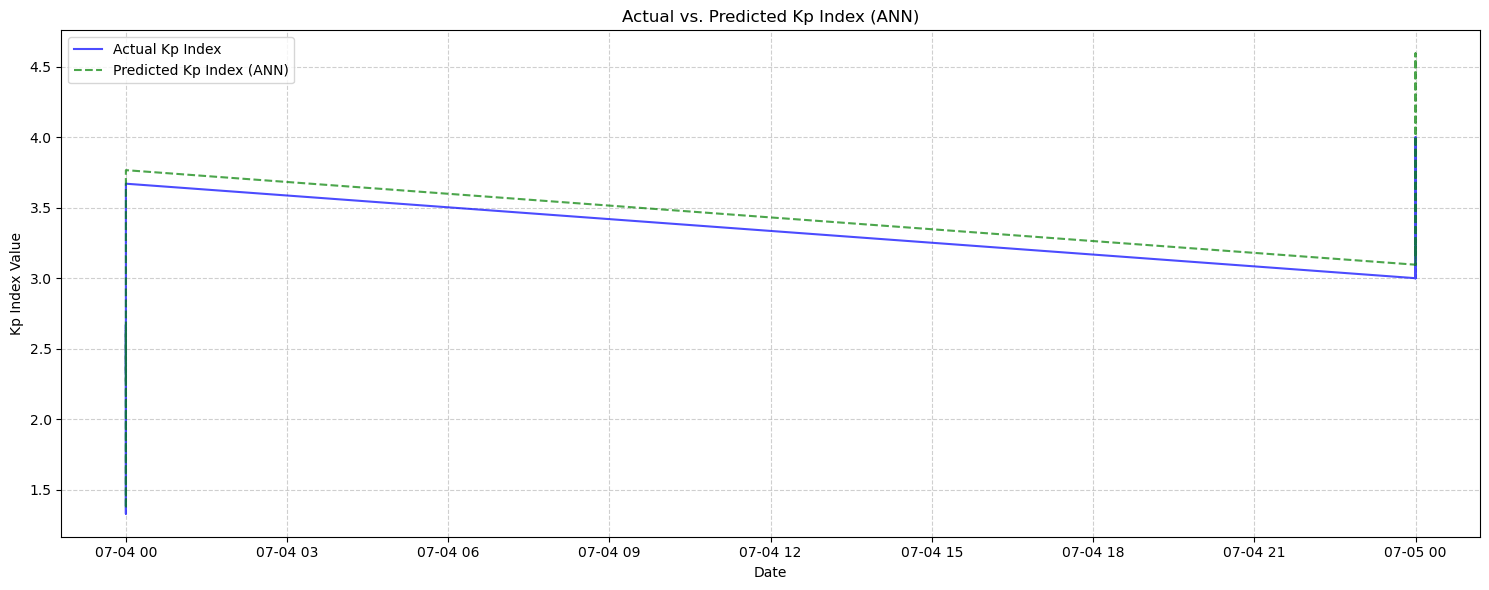

In [48]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MLP Regressor
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                         max_iter=500, random_state=42, verbose=False, learning_rate_init=0.001)

mlp_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_mlp = mlp_model.predict(X_test_scaled)

# Evaluate ANN Model
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mse_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f"ANN (MLP Regressor) - MAE: {mae_mlp:.2f}")
print(f"ANN (MLP Regressor) - MSE: {mse_mlp:.2f}")
print(f"ANN (MLP Regressor) - RMSE: {rmse_mlp:.2f}")
print(f"ANN (MLP Regressor) - R-squared: {r2_mlp:.2f}")

# Plot ANN Predictions vs Actuals
plt.figure(figsize=(15, 6))
plt.plot(test_df['forecast_date'], y_test, label='Actual Kp Index', color='blue', alpha=0.7)
plt.plot(test_df['forecast_date'], y_pred_mlp, label='Predicted Kp Index (ANN)', color='green', linestyle='--', alpha=0.7)
plt.title('Actual vs. Predicted Kp Index (ANN)')
plt.xlabel('Date')
plt.ylabel('Kp Index Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Bayesian Inference

In [56]:
# Suppress noisy PyMC3/ArviZ warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pymc")
warnings.filterwarnings("ignore", category=FutureWarning, module="arviz")
warnings.filterwarnings("ignore", category=UserWarning, module="xarray") # Often related to ArviZ

In [52]:
# 1

#df = historical_df_training

# Introduce some NaNs to Kp_Index_value for demonstration of original_kp_present_mask
missing_kp_indices = np.random.choice(historical_df_training.index, size=int(len(historical_df_training) * 0.1), replace=False)
historical_df_training.loc[missing_kp_indices, 'Kp_Index_value'] = np.nan

# Create Aurora_Chance (Hypothetical)
historical_df_training['Aurora_Chance'] = (
    historical_df_training['Kp_Index_value'].fillna(historical_df_training['Kp_Index_value'].mean()) * 5 +
    historical_df_training['A_index_value'] * 2 -
    historical_df_training['bz_gsm'] * 4 +
    np.random.rand(len(historical_df_training)) * 10
)
historical_df_training['Aurora_Chance'] = np.clip(historical_df_training['Aurora_Chance'], 0, 100)

# Add time-based features
historical_df_training['year'] = historical_df_training['forecast_date'].dt.year
historical_df_training['month'] = historical_df_training['forecast_date'].dt.month
historical_df_training['day_of_year'] = historical_df_training['forecast_date'].dt.dayofyear
historical_df_training['day_of_week'] = historical_df_training['forecast_date'].dt.dayofweek

# Ensure the dataframe is sorted by date before imputation
historical_df_training = historical_df_training.sort_values('forecast_date').reset_index(drop=True)

historical_df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10012 entries, 0 to 10011
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time_tag        10012 non-null  object        
 1   Kp_Index_value  58 non-null     float64       
 2   A_index_value   62 non-null     float64       
 3   station_count   62 non-null     float64       
 4   bx_gsm          10005 non-null  float64       
 5   by_gsm          10005 non-null  float64       
 6   bz_gsm          10005 non-null  float64       
 7   lon_gsm         10005 non-null  float64       
 8   lat_gsm         10005 non-null  float64       
 9   bt              10005 non-null  float64       
 10  forecast_date   10012 non-null  datetime64[ns]
 11  Aurora_Chance   55 non-null     float64       
 12  year            10012 non-null  int32         
 13  month           10012 non-null  int32         
 14  day_of_year     10012 non-null  int32         
 15  da

In [54]:
# 2. Data Prep

# Define features
model_features = ['A_index_value', 'bz_gsm', 'Aurora_Chance',
                  'year', 'month', 'day_of_year', 'day_of_week']
model_target = 'Kp_Index_value'

# Apply imputation to ALL features
imputer_final = SimpleImputer(strategy='mean')
df_imputed = historical_df_training.copy()
df_imputed[model_features + [model_target]] = imputer_final.fit_transform(
    df_imputed[model_features + [model_target]]
)
print("\nAll model features and target imputed for final ML step.")

# Filter out rows where the target is null
original_kp_present_mask = historical_df_training[model_target].notna()
df_supervised = df_imputed[original_kp_present_mask].copy()

# Time-Based Train-Test Split
train_size = int(len(df_supervised) * 0.8)
train_df = df_supervised.iloc[:train_size]
test_df = df_supervised.iloc[train_size:]

X_train_df = train_df[model_features]
y_train_df = train_df[model_target]
X_test_df = test_df[model_features]
y_test_df = test_df[model_target]

# Scale features for the Bayesian model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

# Convert to numpy arrays for PyMC
X_train_np = X_train_scaled
y_train_np = y_train_df.values
X_test_np = X_test_scaled
y_test_np = y_test_df.values

print(f"\nTraining data shape (X_train_np): {X_train_np.shape}, (y_train_np): {y_train_np.shape}")
print(f"Testing data shape (X_test_np): {X_test_np.shape}, (y_test_np): {y_test_np.shape}")


All model features and target imputed for final ML step.

Training data shape (X_train_np): (46, 7), (y_train_np): (46,)
Testing data shape (X_test_np): (12, 7), (y_test_np): (12,)


In [58]:
#3. Define the Bayesian Linear Regression Model
#pm.Model() = probabilistic model 

with pm.Model(coords={"features": model_features}) as bayesian_model:
    X_shared = pm.Data("X_shared", X_train_np, dims=("N_samples", "features"))
    Y_obs_shared = pm.Data("Y_obs_shared", y_train_np, dims="N_samples")
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1, dims="features")
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = pt.add(intercept, pt.dot(X_shared, beta))
    Y_pred = pm.Deterministic("Y_pred", mu, dims="N_samples")
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y_obs_shared, dims="N_samples")

In [60]:
#4. Perform Inference

with bayesian_model:
    trace = pm.sample(draws=2000, tune=1000, cores=2, random_seed=42, return_inferencedata=True)
    
print("\nSampling Complete")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, beta, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 928 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Sampling Complete


                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta[A_index_value]  0.581  0.069   0.453    0.709      0.002    0.001   
beta[bz_gsm]         0.105  0.097  -0.093    0.270      0.003    0.002   
beta[Aurora_Chance]  0.146  0.128  -0.113    0.364      0.003    0.002   
beta[year]          -0.009  0.969  -1.928    1.671      0.014    0.015   
beta[month]         -0.063  0.056  -0.172    0.035      0.001    0.001   
beta[day_of_year]    0.002  0.057  -0.106    0.109      0.001    0.001   
beta[day_of_week]    0.010  0.029  -0.044    0.065      0.000    0.001   
sigma                0.174  0.021   0.140    0.216      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
beta[A_index_value]    1427.0    2150.0    1.0  
beta[bz_gsm]           1462.0    2157.0    1.0  
beta[Aurora_Chance]    1405.0    2019.0    1.0  
beta[year]             4744.0    3050.0    1.0  
beta[month]            2671.0    2698.0    1.0  
beta[day_of_year]      2708.0    2638.0

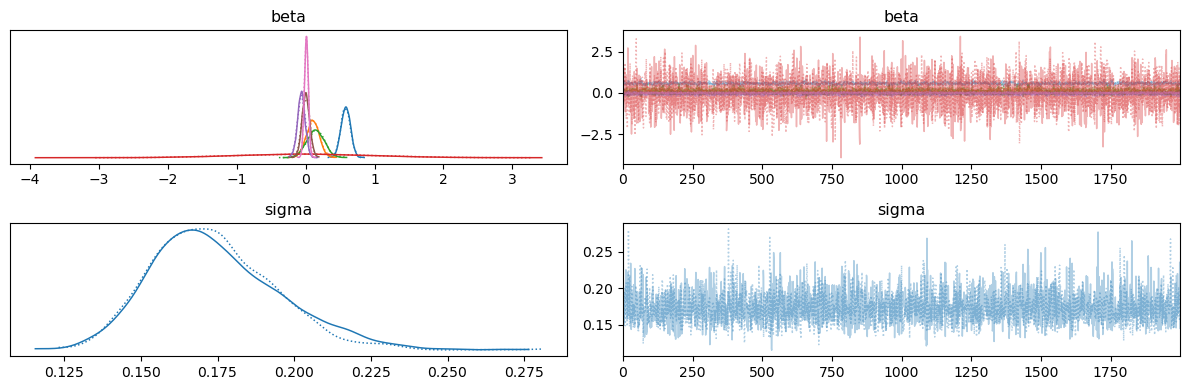

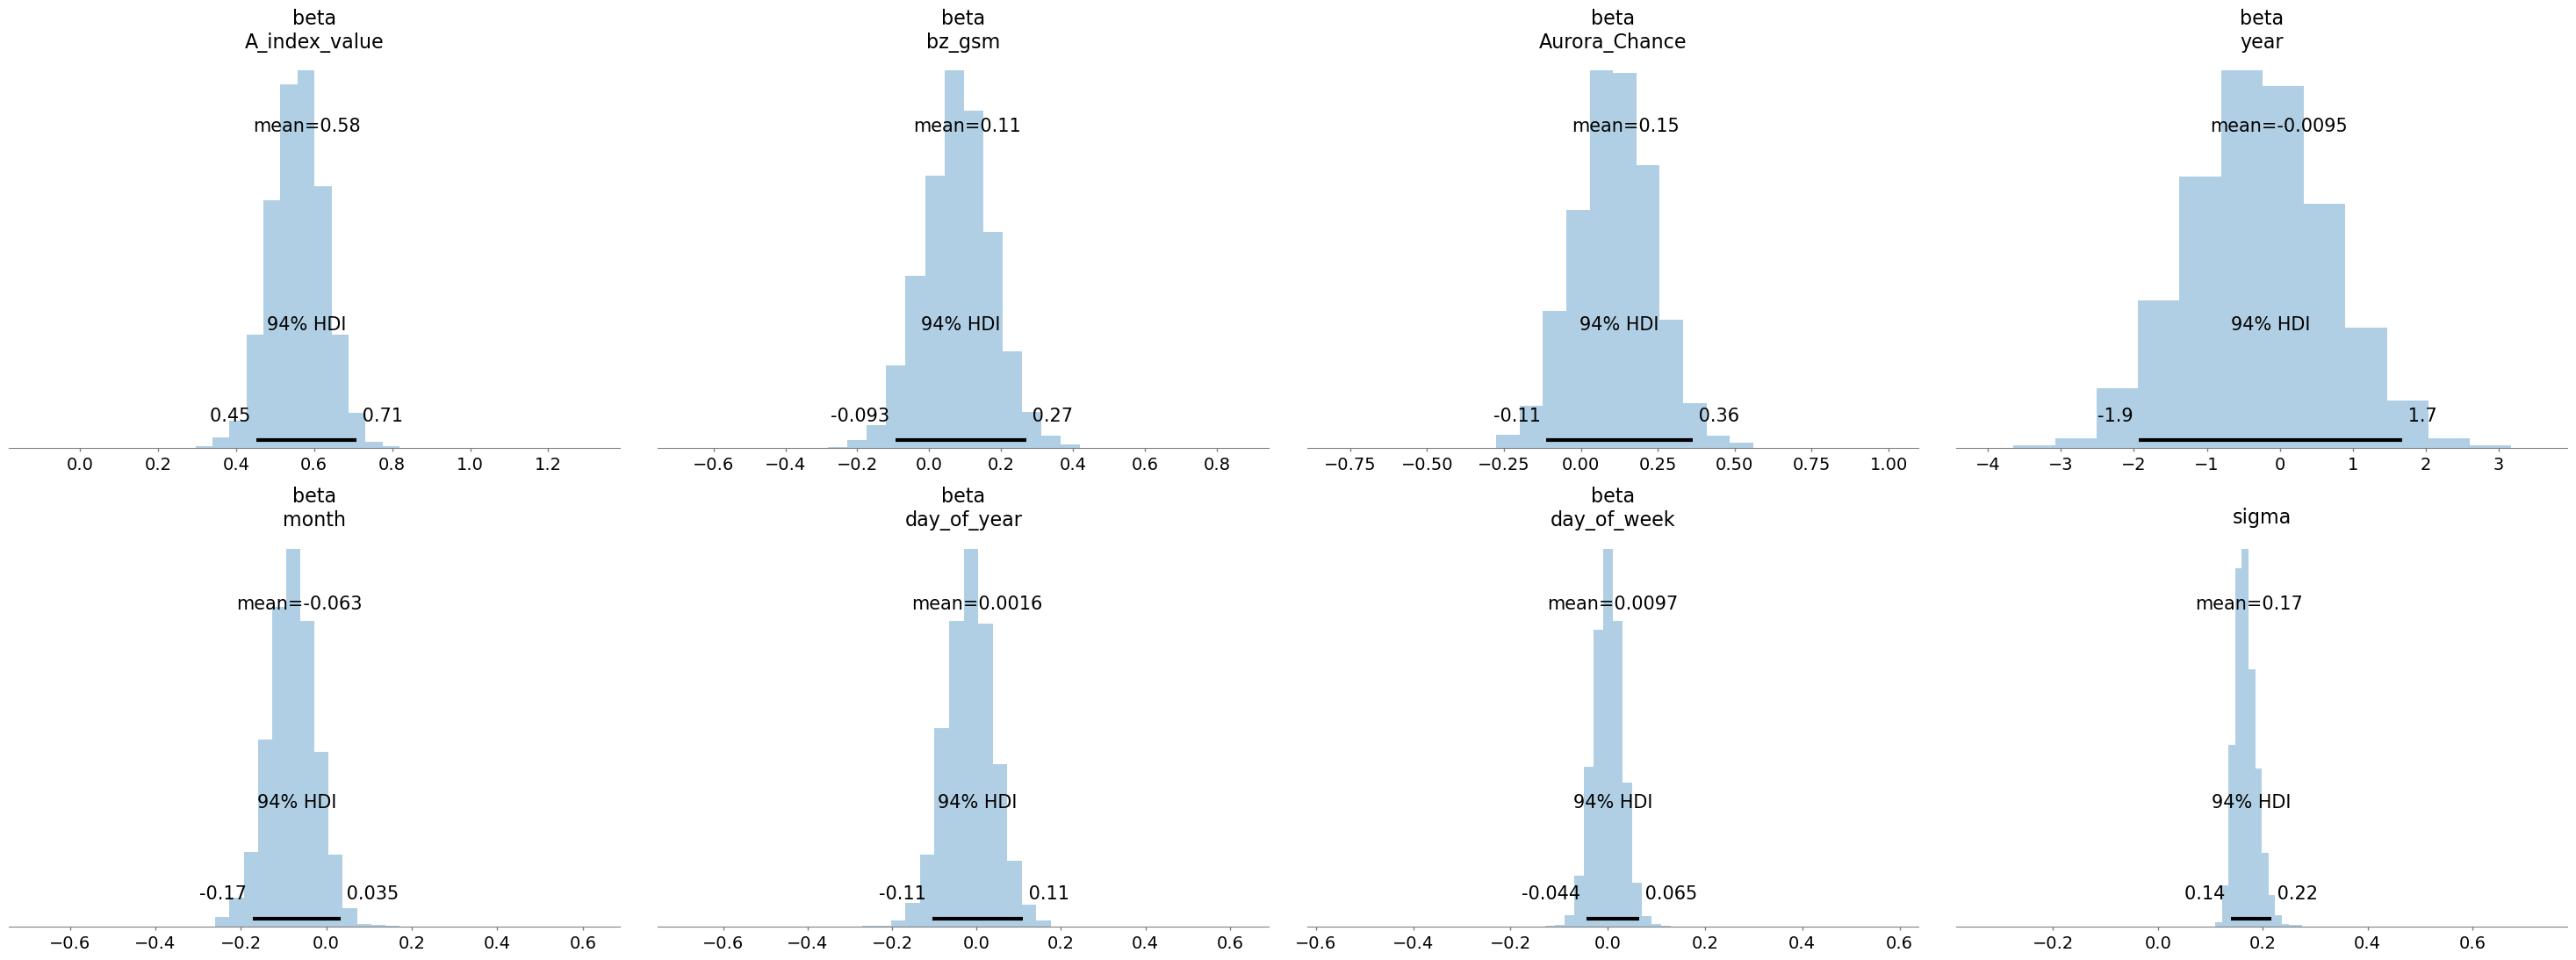

In [62]:
# 5. Analyze Posterior Samples
# Summary Stats
print(az.summary(trace, var_names=["beta", "sigma"]))

# Check for Convergence
az.plot_trace(trace, var_names=["beta", "sigma"])
plt.tight_layout()
plt.show()

# Plot posterior distributions of parameters
az.plot_posterior(trace, var_names=["beta", "sigma"], kind="hist")
plt.tight_layout()
plt.show()

In [63]:
#6. Make Predictions on Test Data

# Update data container with test features
with bayesian_model:
    pm.set_data({"X_shared": X_test_np})
    ppc = pm.sample_posterior_predictive(trace, var_names=["Y_obs"], extend_inferencedata=True)

# The posterior predictive samples are in ppc.posterior_predictive['Y_obs']

y_pred_bayesian_mean = ppc.posterior_predictive["Y_obs"].mean(axis=(0, 1))

# Intervals for uncertainty
hdi_94 = az.hdi(ppc.posterior_predictive["Y_obs"], hdi_prob=0.94)

Sampling: [Y_obs]


Output()

In [66]:
#  7. Evaluate Bayesian Model Predictions

mae_bayesian = mean_absolute_error(y_test_np, y_pred_bayesian_mean)
mse_bayesian = mean_squared_error(y_test_np, y_pred_bayesian_mean)
rmse_bayesian = np.sqrt(mse_bayesian)
r2_bayesian = r2_score(y_test_np, y_pred_bayesian_mean)

print(f"Bayesian Linear Regression - MAE: {mae_bayesian:.2f}")
print(f"Bayesian Linear Regression - MSE: {mse_bayesian:.2f}")
print(f"Bayesian Linear Regression - RMSE: {rmse_bayesian:.2f}")
print(f"Bayesian Linear Regression - R-squared: {r2_bayesian:.2f}")

Bayesian Linear Regression - MAE: 0.16
Bayesian Linear Regression - MSE: 0.06
Bayesian Linear Regression - RMSE: 0.24
Bayesian Linear Regression - R-squared: 0.85


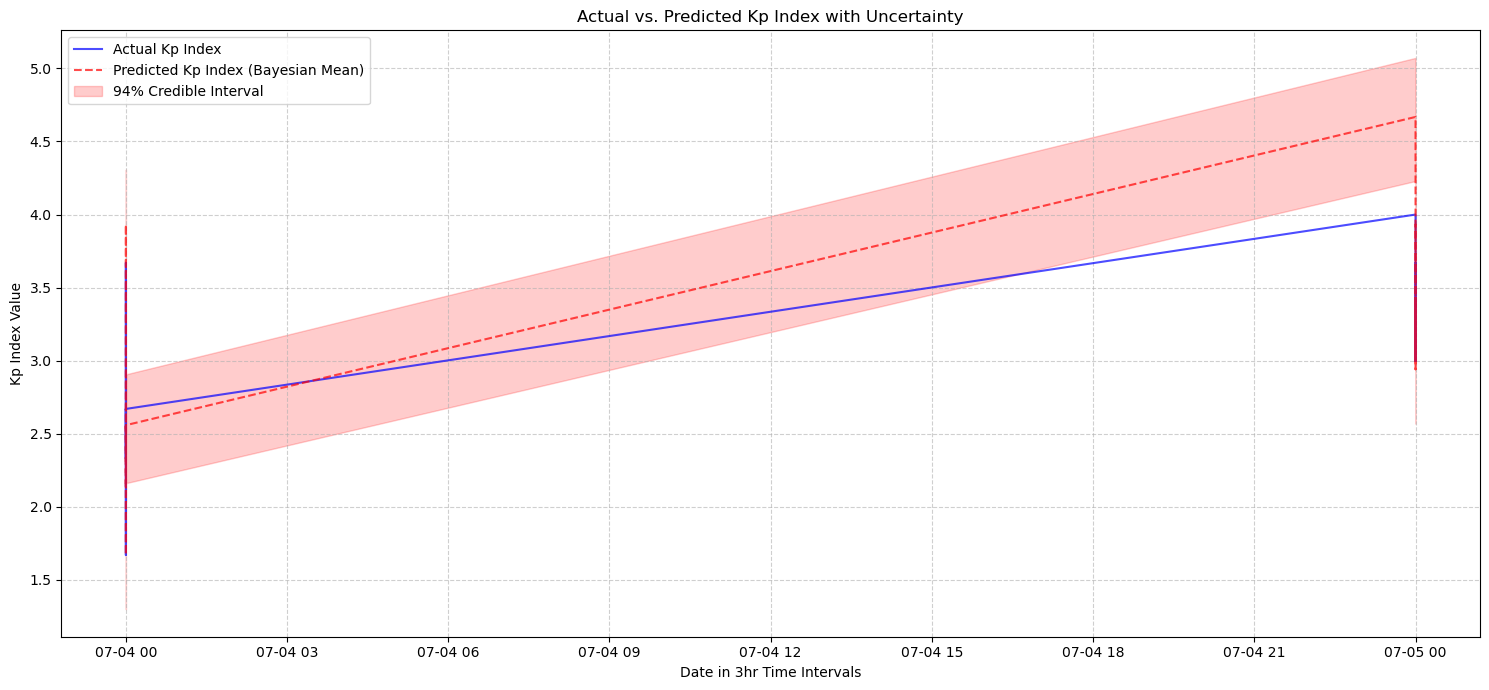

In [68]:
# 8. Visualize Bayesian Predictions with Uncertainty
plt.figure(figsize=(15, 7))
plt.plot(test_df['forecast_date'], y_test_np, label='Actual Kp Index', color='blue', alpha=0.7)
plt.plot(test_df['forecast_date'], y_pred_bayesian_mean, label='Predicted Kp Index (Bayesian Mean)', color='red', linestyle='--', alpha=0.7)

# Plot credible interval (e.g., 94% HDI)
plt.fill_between(
    test_df['forecast_date'],
    hdi_94["Y_obs"][:, 0], # Lower bound of HDI
    hdi_94["Y_obs"][:, 1], # Upper bound of HDI
    color='red', alpha=0.2, label='94% Credible Interval'
)

plt.title('Actual vs. Predicted Kp Index with Uncertainty')
plt.xlabel('Date in 3hr Time Intervals')
plt.ylabel('Kp Index Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Clustering

In [70]:
#historical_df_training = historical_df.copy()

num_days = len(historical_df)

# Introduce some random NaNs for demonstration purposes
for col in ['Kp_Index_value', 'A_index_value', 'bz_gsm']:
    missing_indices = np.random.choice(historical_df_training.index, size=int(num_days * 0.15), replace=False)
    historical_df_training.loc[missing_indices, col] = np.nan

# Create a hypothetical 'Aurora_Chance' for analysis of clusters
historical_df_training['Aurora_Chance'] = (
    historical_df_training['Kp_Index_value'].fillna(historical_df_training['Kp_Index_value'].mean()) * 5 +
    historical_df_training['A_index_value'].fillna(historical_df_training['A_index_value'].mean()) * 2 -
    historical_df_training['bz_gsm'].fillna(historical_df_training['bz_gsm'].mean()) * 4 +
    np.random.rand(num_days) * 10
)
historical_df_training['Aurora_Chance'] = np.clip(historical_df_training['Aurora_Chance'], 0, 100)

historical_df_training = historical_df_training.sort_values('forecast_date').reset_index(drop=True)

print("--- Sample Historical DataFrame Head (with potential NaNs) ---")
print(historical_df_training.head())
print("\n--- Sample Historical DataFrame Info (check for NaNs) ---")
historical_df_training.info()

--- Sample Historical DataFrame Head (with potential NaNs) ---
                  time_tag  Kp_Index_value  A_index_value  station_count  \
0  2025-06-28 00:00:00.000             NaN            6.0            8.0   
1  2025-06-28 21:22:00.000             NaN            NaN            NaN   
2  2025-06-28 03:00:00.000            2.33            9.0            8.0   
3  2025-06-28 06:00:00.000            3.33           18.0            8.0   
4  2025-06-28 09:00:00.000            2.67           12.0            8.0   

   bx_gsm  by_gsm  bz_gsm  lon_gsm  lat_gsm    bt forecast_date  \
0     NaN     NaN     NaN      NaN      NaN   NaN    2025-06-28   
1    1.49   -3.49    1.74   293.13    24.61  4.18    2025-06-28   
2     NaN     NaN     NaN      NaN      NaN   NaN    2025-06-28   
3     NaN     NaN     NaN      NaN      NaN   NaN    2025-06-28   
4     NaN     NaN     NaN      NaN      NaN   NaN    2025-06-28   

   Aurora_Chance  year  month  day_of_year  day_of_week  
0      31.493041  2

In [72]:
#2. Define Features for Clustering

clustering_features = ['Kp_Index_value', 'A_index_value', 'bz_gsm']
X_cluster = historical_df_training[clustering_features].copy()

In [74]:
#3. Handle Missing Values

imputer_cluster = SimpleImputer(strategy='mean')
X_cluster_imputed = imputer_cluster.fit_transform(X_cluster)
X_cluster_processed = pd.DataFrame(X_cluster_imputed, columns=clustering_features, index=X_cluster.index)
print(f"\nMissing values in {clustering_features} imputed using '{imputer_cluster.strategy}' strategy.")
print(f"X_cluster_processed shape: {X_cluster_processed.shape}")


Missing values in ['Kp_Index_value', 'A_index_value', 'bz_gsm'] imputed using 'mean' strategy.
X_cluster_processed shape: (10012, 3)


In [76]:
# 4. Feature Scaling
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster_processed)
X_cluster_scaled_df = pd.DataFrame(X_cluster_scaled, columns=clustering_features, index=X_cluster_processed.index)
print("\nClustering features scaled (StandardScaler).")
print(f"X_cluster_scaled_df head:\n{X_cluster_scaled_df.head()}")


Clustering features scaled (StandardScaler).
X_cluster_scaled_df head:
   Kp_Index_value  A_index_value    bz_gsm
0        0.000000  -1.068518e+01  0.000000
1        0.000000   4.195006e-15  0.741341
2        0.072042  -3.600440e+00  0.000000
3       19.989422   1.765377e+01  0.000000
4        6.843951   3.484296e+00  0.000000


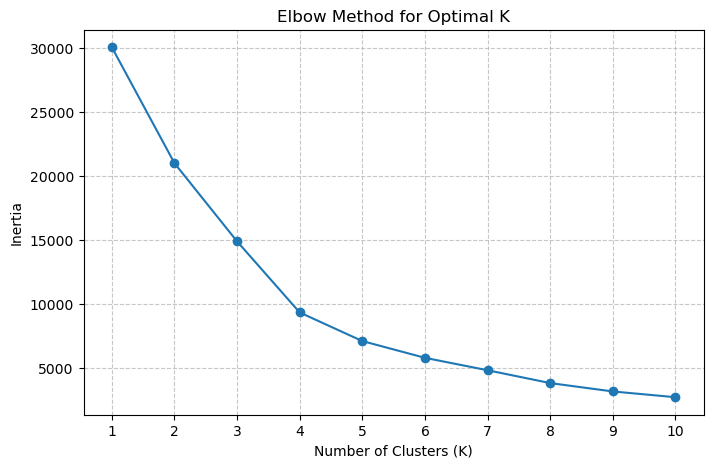

In [78]:
# 5. Optimal number of clusters
inertia = []
k_range = range(1, 11) # Test K from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init to suppress warning
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [79]:
# 6. Apply K-Means
optimal_k = 4
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Fit the model and get cluster labels
cluster_labels = kmeans_model.fit_predict(X_cluster_scaled)

# Add the cluster labels back to your original historical DataFrame
historical_df_training['Cluster'] = pd.Series(cluster_labels, index=X_cluster_processed.index)

print(f"Assigned {optimal_k} clusters to the data.")
print(f"Value counts for clusters:\n{historical_df_training['Cluster'].value_counts()}")

Assigned 4 clusters to the data.
Value counts for clusters:
Cluster
3    7737
0    2242
1      22
2      11
Name: count, dtype: int64


In [80]:
# 7. Analyze Cluster Characteristics

# Inverse transform cluster centers to original scale for better interpretation
cluster_centers_scaled = kmeans_model.cluster_centers_
cluster_centers_original_scale = scaler_cluster.inverse_transform(cluster_centers_scaled)
cluster_centers_df = pd.DataFrame(cluster_centers_original_scale, columns=clustering_features)

# Also, calculate the mean of the 'Aurora_Chance' for each cluster
cluster_centers_df['Aurora_Chance_Mean'] = historical_df_training.groupby('Cluster')['Aurora_Chance'].mean()
print(cluster_centers_df)

   Kp_Index_value  A_index_value    bz_gsm  Aurora_Chance_Mean
0        2.326537      10.526558  3.996318           21.976899
1        1.697108       5.863636 -0.148606           25.169869
2        3.302398      19.454545 -1.621892           66.741566
3        2.326740      10.524575 -2.283835           46.771388


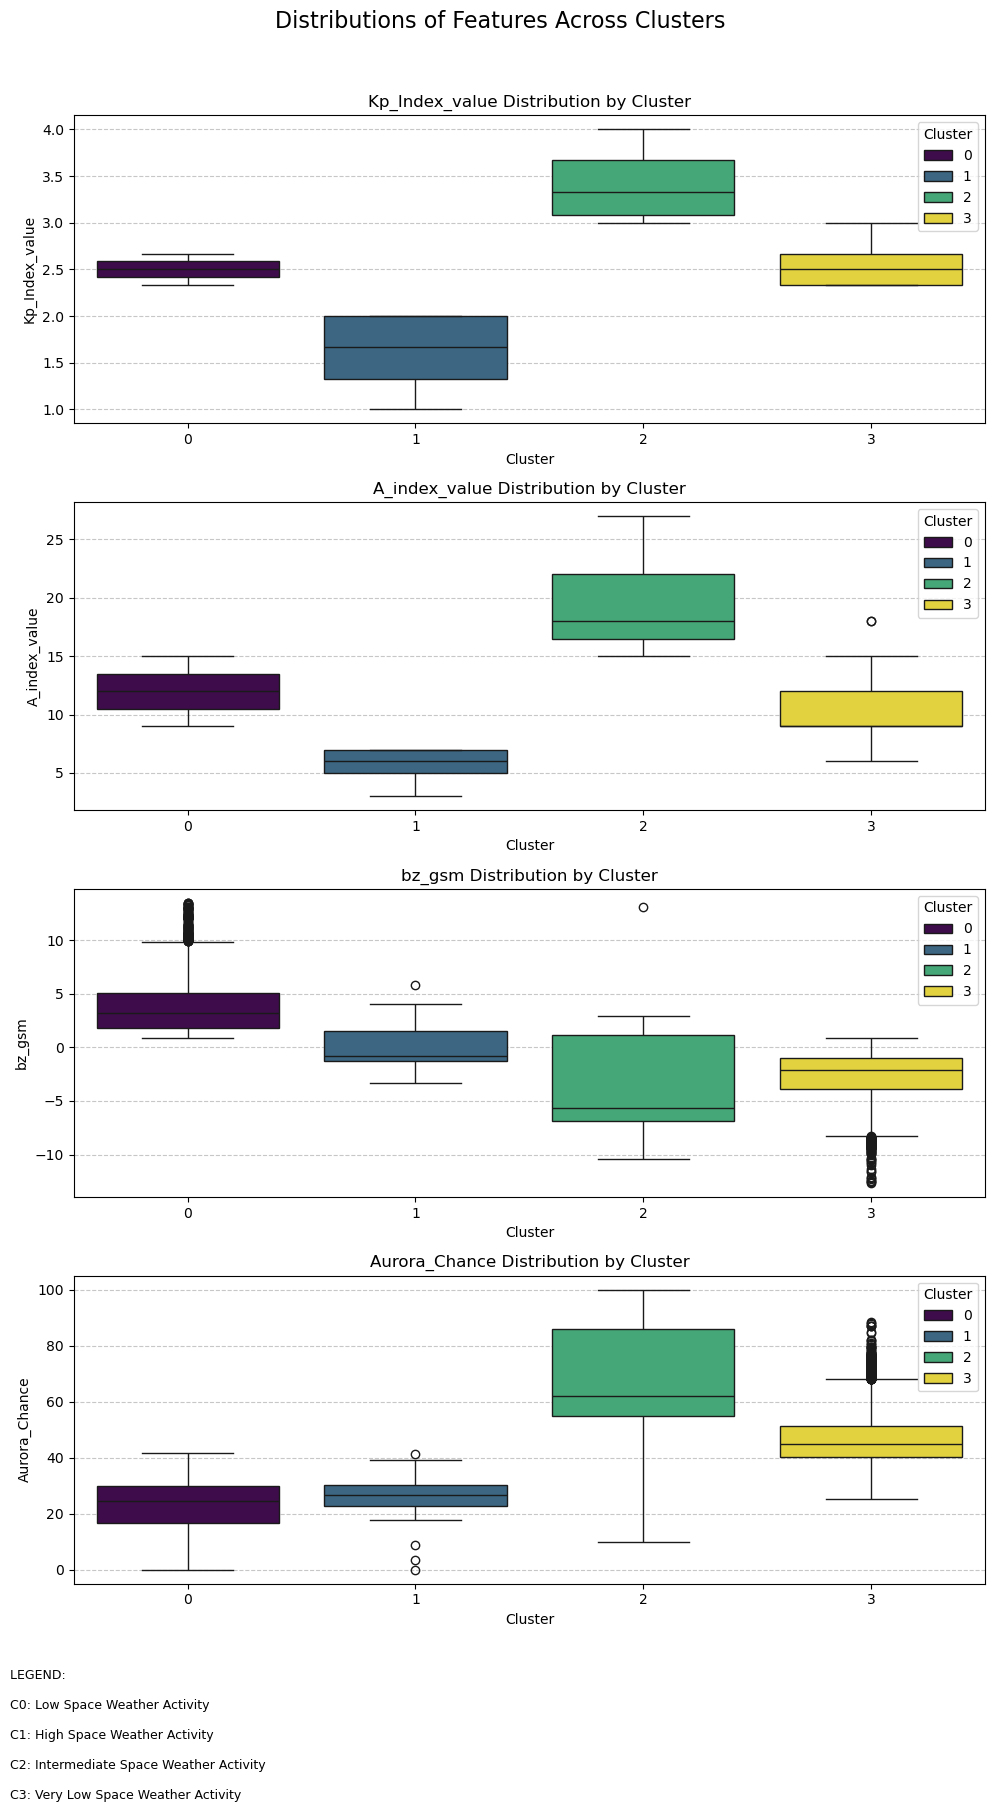

In [82]:
# 8. Cluster Visuals
features_for_plot = clustering_features + ['Aurora_Chance']
fig, axes = plt.subplots(nrows=len(features_for_plot), ncols=1, figsize=(10, 4 * len(features_for_plot)))

for i, feature in enumerate(features_for_plot):
    sns.boxplot(x='Cluster', y=feature, data=historical_df_training, ax=axes[i], palette='viridis', hue='Cluster')
    axes[i].set_title(f'{feature} Distribution by Cluster')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.subplots_adjust(bottom=0.1)
plt.suptitle('Distributions of Features Across Clusters', y=1.02, fontsize=16)
fig.text(0.01, -0.1, """LEGEND: \n\nC0: Low Space Weather Activity 
    \nC1: High Space Weather Activity 
    \nC2: Intermediate Space Weather Activity 
    \nC3: Very Low Space Weather Activity""", va='bottom', ha='left', fontsize=9)
plt.tight_layout()
plt.show()

### PCA

In [86]:
historical_df.head()

,time_tag,Kp_Index_value,A_index_value,station_count,bx_gsm,by_gsm,bz_gsm,lon_gsm,lat_gsm,bt,forecast_date
0,2025-06-28 00:00:00.000,1.67,6.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-28
1,2025-06-28 03:00:00.000,2.33,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-28
2,2025-06-28 06:00:00.000,3.33,18.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-28
3,2025-06-28 09:00:00.000,2.67,12.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-28
4,2025-06-28 12:00:00.000,2.00,7.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-28


In [88]:
# 1)

#drop null
historical_df_NONULL = historical_df.dropna()
historical_df_NONULL = historical_df_NONULL[['Kp_Index_value','A_index_value','bz_gsm']]

X = historical_df_NONULL.drop(columns=['Kp_Index_value']) # leave target columns
y = historical_df_NONULL['Kp_Index_value'] # continuous

num_bins = 12
y = pd.qcut(y, q=num_bins, labels=False, duplicates='drop') #Added for equivalent sampling

pca = PCA()
scaler = StandardScaler()
logistic = LogisticRegression(max_iter=10000, tol=0.1, random_state=42) # Using LogisticRegression
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])

param_grid = {
    "pca__n_components": [1,2],
    "logistic__C": np.logspace(-4, 4, 4),
}

search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

C:\Users\paesk\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best parameter (CV score=0.436):
{'logistic__C': 10000.0, 'pca__n_components': 2}


C:\Users\paesk\AppData\Local\Temp\ipykernel_26572\429689200.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_clfs = results.groupby(components_col).apply(


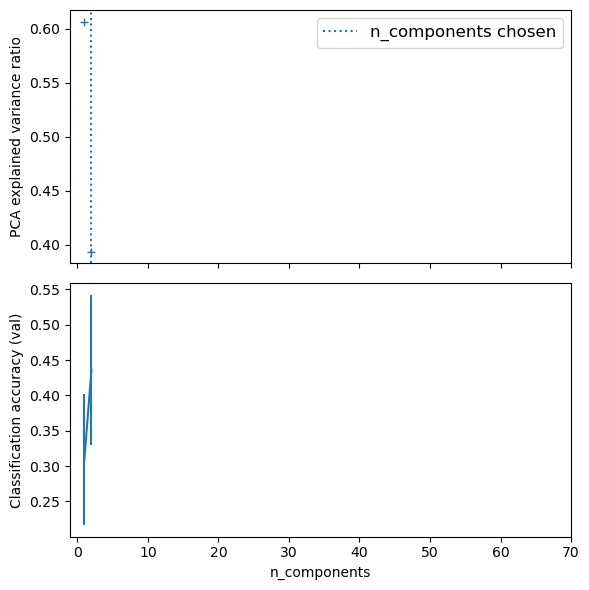

In [89]:
chosen_n_components = 2

#----ADDED FOR BETTER VARIANCE VISUAL
scaler_plot = StandardScaler()
X_scaled_for_pca_plot = scaler_plot.fit_transform(X)
pca_for_plot = PCA()
pca_for_plot.fit(X_scaled_for_pca_plot)
#------------------------------

# PLOT CONT.
pca.fit(X_scaled_for_pca_plot)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

# Model evaluation methods

### ANN

ANN (MLP Regressor) - MAE: 0.14
ANN (MLP Regressor) - MSE: 0.05
ANN (MLP Regressor) - RMSE: 0.21
ANN (MLP Regressor) - R-squared: 0.94


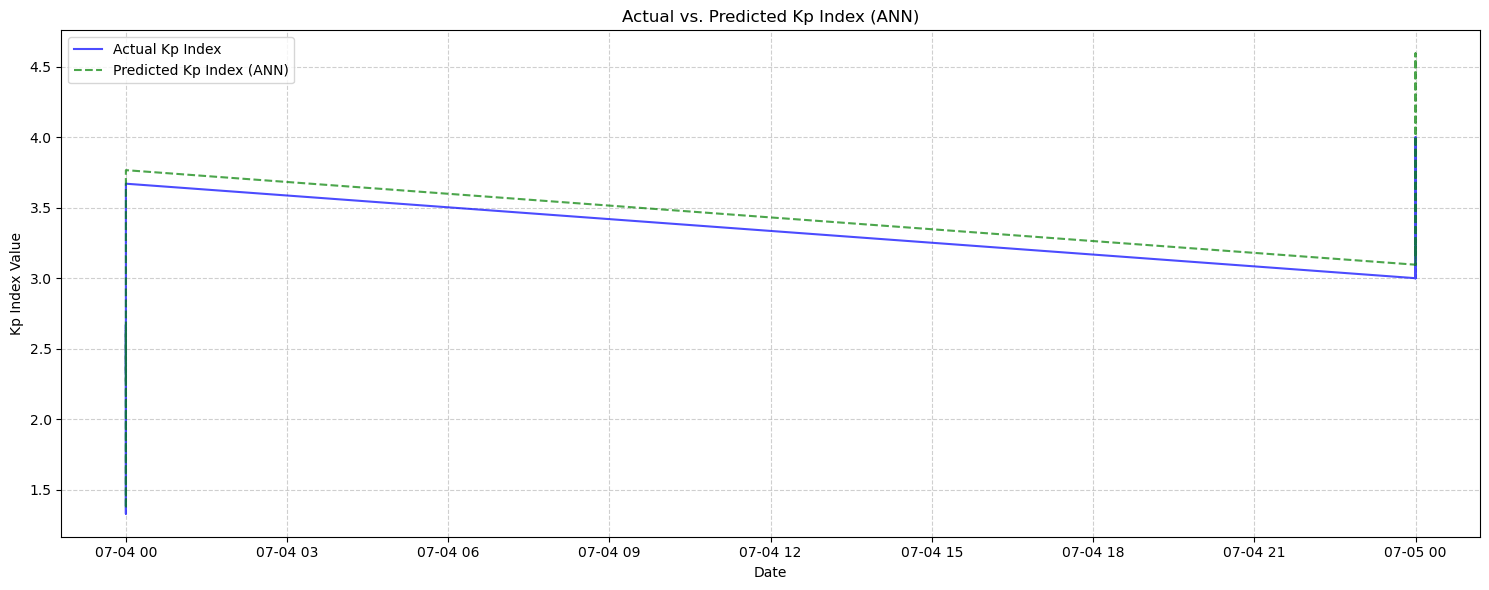

In [92]:
historical_df_training = historical_df.copy()
historical_df_training['forecast_date'] = pd.to_datetime(historical_df_training['forecast_date'])

# 1. Select all features
features = ['Kp_Index_value', 'A_index_value', 'bz_gsm']

df_model_ready = historical_df_training[features].copy()

# Impute only the features (X) before splitting
df_model_ready = df_model_ready.ffill().bfill()

X = df_model_ready[['A_index_value', 'bz_gsm']]
y = df_model_ready['Kp_Index_value']

# Identify rows where Kp_Index_value is not null
original_kp_present_mask = historical_df_training['Kp_Index_value'].notna()

X_supervised = df_model_ready[original_kp_present_mask].copy() # Features for observed Kp rows
y_supervised = y[original_kp_present_mask].copy() # Observed Kp values

df_for_split = historical_df_training.copy()
df_for_split['Kp_Index_value_imputed'] = df_model_ready['Kp_Index_value']

# Define full set of features to be used in the model, *excluding* original Kp
model_features = ['A_index_value', 'bz_gsm']
model_target = 'Kp_Index_value'

# Apply imputation to features and target
# Using SimpleImputer here for robustness, instead of ffill/bfill for final model data.
imputer_final = SimpleImputer(strategy='mean')
df_for_split[model_features + [model_target]] = imputer_final.fit_transform(
    df_for_split[model_features + [model_target]]
)

# Filter out rows where model_target was NaN
df_for_split_supervised = df_for_split[original_kp_present_mask].copy()

train_size = int(len(df_for_split_supervised) * 0.8)
train_df = df_for_split_supervised.iloc[:train_size]
test_df = df_for_split_supervised.iloc[train_size:]

X_train = train_df[model_features]
y_train = train_df[model_target]
X_test = test_df[model_features]
y_test = test_df[model_target]

df_for_split_supervised = df_for_split[original_kp_present_mask].copy()

train_size = int(len(df_for_split_supervised) * 0.8)
test_df = df_for_split_supervised.iloc[train_size:]

mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mse_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f"ANN (MLP Regressor) - MAE: {mae_mlp:.2f}")
print(f"ANN (MLP Regressor) - MSE: {mse_mlp:.2f}")
print(f"ANN (MLP Regressor) - RMSE: {rmse_mlp:.2f}")
print(f"ANN (MLP Regressor) - R-squared: {r2_mlp:.2f}")

# Plot ANN Predictions vs Actuals
plt.figure(figsize=(15, 6))
plt.plot(test_df['forecast_date'], y_test, label='Actual Kp Index', color='blue', alpha=0.7)
plt.plot(test_df['forecast_date'], y_pred_mlp, label='Predicted Kp Index (ANN)', color='green', linestyle='--', alpha=0.7)
plt.title('Actual vs. Predicted Kp Index (ANN)')
plt.xlabel('Date')
plt.ylabel('Kp Index Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Bayesian Inference

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta[A_index_value]  0.581  0.069   0.453    0.709      0.002    0.001   
beta[bz_gsm]         0.105  0.097  -0.093    0.270      0.003    0.002   
beta[Aurora_Chance]  0.146  0.128  -0.113    0.364      0.003    0.002   
beta[year]          -0.009  0.969  -1.928    1.671      0.014    0.015   
beta[month]         -0.063  0.056  -0.172    0.035      0.001    0.001   
beta[day_of_year]    0.002  0.057  -0.106    0.109      0.001    0.001   
beta[day_of_week]    0.010  0.029  -0.044    0.065      0.000    0.001   
sigma                0.174  0.021   0.140    0.216      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
beta[A_index_value]    1427.0    2150.0    1.0  
beta[bz_gsm]           1462.0    2157.0    1.0  
beta[Aurora_Chance]    1405.0    2019.0    1.0  
beta[year]             4744.0    3050.0    1.0  
beta[month]            2671.0    2698.0    1.0  
beta[day_of_year]      2708.0    2638.0

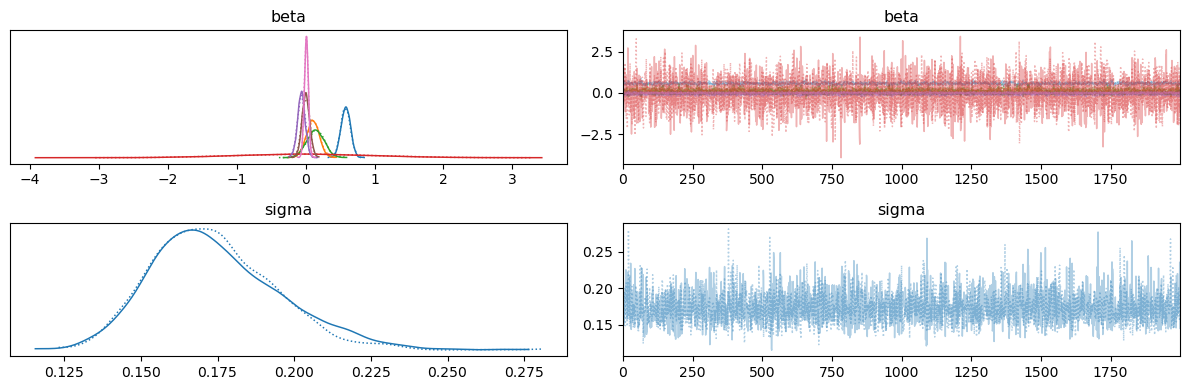

In [94]:
# Summary Stats
print(az.summary(trace, var_names=["beta", "sigma"]))

# Check for Convergence
az.plot_trace(trace, var_names=["beta", "sigma"])
plt.tight_layout()
plt.show()

### Cluster

In [96]:
from sklearn.metrics import silhouette_score

clustering_features = ['Kp_Index_value', 'A_index_value', 'bz_gsm']
X_cluster = historical_df_training[clustering_features].copy()
X_cluster_processed = pd.DataFrame(X_cluster_imputed, columns=clustering_features, index=X_cluster.index)
historical_df_training['Cluster'] = pd.Series(cluster_labels, index=X_cluster_processed.index)

score = silhouette_score(X_cluster_scaled, historical_df_training['Cluster'])
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.58


### PCA

C:\Users\paesk\AppData\Local\Temp\ipykernel_26572\429689200.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_clfs = results.groupby(components_col).apply(


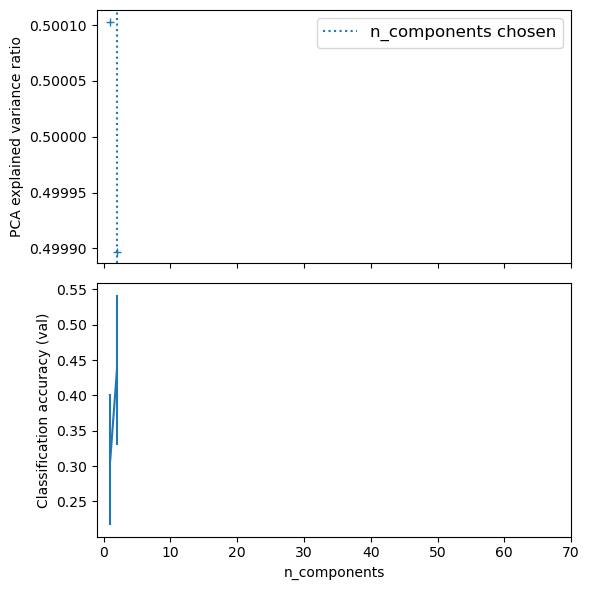

In [98]:
chosen_n_components = 2

#----ADDED FOR BETTER VARIANCE VISUAL
scaler_plot = StandardScaler()
X_scaled_for_pca_plot = scaler_plot.fit_transform(X)
pca_for_plot = PCA()
pca_for_plot.fit(X_scaled_for_pca_plot)
#------------------------------

# PLOT CONT.
pca.fit(X_scaled_for_pca_plot)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

# Works Cited

"Science: Solar Wind", *NASA - Jet Propulsion Laboratory* https://www.jpl.nasa.gov/nmp/st5/SCIENCE/solarwind.html#:~:text=The%20solar%20wind%20is%20created,lines%20that%20extend%20radially%20outward. Retrieved 5 July 2025.

"Tips on Viewing the Aurora", *NOAA - Space Weather Prediction Center*, https://www.swpc.noaa.gov/content/tips-viewing-aurora. Retrieved 5 July 2025.

"Index of Products", *NOAA - Space Weather Prediction Center*, https://services.swpc.noaa.gov/products/. Retrieved 5 July 2025.